In [1]:
!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

     |████████████████████████████████| 522.4MB 29kB/s 
     |████████████████████████████████| 460kB 47.6MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 3.0MB 47.6MB/s 


In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZIJ2C8/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZIJ2C8/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZIJ2C8/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [0]:
encoder = info.features['text'].encoder

In [5]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [6]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [0]:
assert original_string == sample_string

In [8]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

In [0]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 833s 2s/step - loss: 0.6705 - accuracy: 0.5294 - val_loss: 0.5693 - val_accuracy: 0.6365
Epoch 2/10
391/391 [==============================] - 833s 2s/step - loss: 0.3821 - accuracy: 0.8296 - val_loss: 0.3590 - val_accuracy: 0.8323
Epoch 3/10
391/391 [==============================] - 837s 2s/step - loss: 0.2538 - accuracy: 0.8994 - val_loss: 0.3250 - val_accuracy: 0.8651
Epoch 4/10
391/391 [==============================] - 833s 2s/step - loss: 0.2129 - accuracy: 0.9217 - val_loss: 0.3354 - val_accuracy: 0.8755
Epoch 5/10
391/391 [==============================] - 828s 2s/step - loss: 0.1829 - accuracy: 0.9326 - val_loss: 0.3351 - val_accuracy: 0.8693
Epoch 6/10
391/391 [==============================] - 831s 2s/step - loss: 0.1742 - accuracy: 0.9355 - val_loss: 0.3563 - val_accuracy: 0.8714
Epoch 7/10
391/391 [==============================] - 830s 2s/step - loss: 0.1471 - accuracy: 0.9496 - val_loss: 0.3909 - val_accuracy: 0.8693

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 185s 473ms/step - loss: 0.4477 - accuracy: 0.8560
Test Loss: 0.44768527150154114
Test Accuracy: 0.8559600114822388


In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [18]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.4061129]]


In [19]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.66135526]]


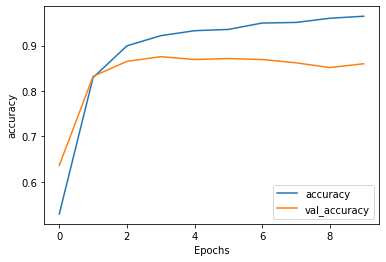

In [20]:
plot_graphs(history, 'accuracy')

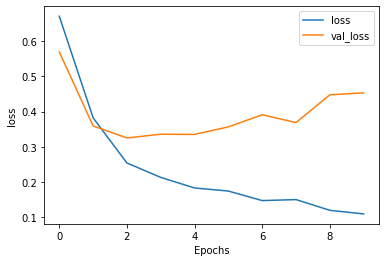

In [21]:
plot_graphs(history, 'loss')